# Social Network Ads Conversion Prediction

**Author:** Senior Machine Learning Engineer  
**Topic:** Supervised Classification (Logistic Regression)

---

# STEP 1: Problem Definition

### 1.1 Business Problem
A car company has just launched a new luxury SUV. They ran ads on a social network and collected data on whether users purchased the car after seeing the ad.
Our goal is to build an automated model to **predict if a user will purchase the SUV** based on their Age and Estimated Salary. This will help the marketing team target the right audience and save advertising budget.

### 1.2 Classification vs. Regression
- **Target:** `Purchased` (0 = No, 1 = Yes).
- Since the output is categorical (Purchase or Not Purchase), this is a **Binary Classification** problem. Regression is not suitable because we are not predicting a continuous number (like price).

### 1.3 Features & Target
- **Features:**
    - `Gender`: Male/Female
    - `Age`: Age in years
    - `EstimatedSalary`: Annual salary
- **Target Variable:** `Purchased`

---

# STEP 2: Data Loading & Understanding

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Setting visualization style
plt.style.use('seaborn-v0_8-darkgrid')
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

In [11]:
# Load the dataset
try:
    df = pd.read_csv('csv_files/social_network_ads.csv')
    print("Dataset Loaded Successfully!")
except FileNotFoundError:
    print("File not found. Please check the path.")

Dataset Loaded Successfully!


In [12]:
# Display first 5 rows
print(f"Shape of dataset: {df.shape}")
display(df.head())

Shape of dataset: (400, 5)


,user_id,gender,age,estimated_salary,purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


In [13]:
# Overview of data types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_id           400 non-null    int64 
 1   gender            400 non-null    object
 2   age               400 non-null    int64 
 3   estimated_salary  400 non-null    int64 
 4   purchased         400 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 15.8+ KB


In [14]:
# Statistical summary
df.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,400.0,1.569154e+07,71658.321581,15566689.0,15626763.75,15694341.5,15750363.0,15815236.0
age,400.0,3.765500e+01,10.482877,18.0,29.75,37.0,46.0,60.0
estimated_salary,400.0,6.974250e+04,34096.960282,15000.0,43000.00,70000.0,88000.0,150000.0
purchased,400.0,3.575000e-01,0.479864,0.0,0.00,0.0,1.0,1.0


In [15]:
# Drop 'User ID' column
# Justification: User ID is just a random identifier and has no predictive power for purchasing behavior.
if 'User ID' in df.columns:
    df.drop(columns=['User ID'], inplace=True)
    print("Dropped 'User ID' column.")
elif 'user_id' in df.columns:
    df.drop(columns=['user_id'], inplace=True)
    print("Dropped 'user_id' column.")
else:
    print("User ID column not found or already dropped.")

display(df.head())

Dropped 'user_id' column.


,gender,age,estimated_salary,purchased
0,Male,19,19000,0
1,Male,35,20000,0
2,Female,26,43000,0
3,Female,27,57000,0
4,Male,19,76000,0


---
# STEP 3: Exploratory Data Analysis (EDA)
Visualizing the relationships between features and purchasing behavior.

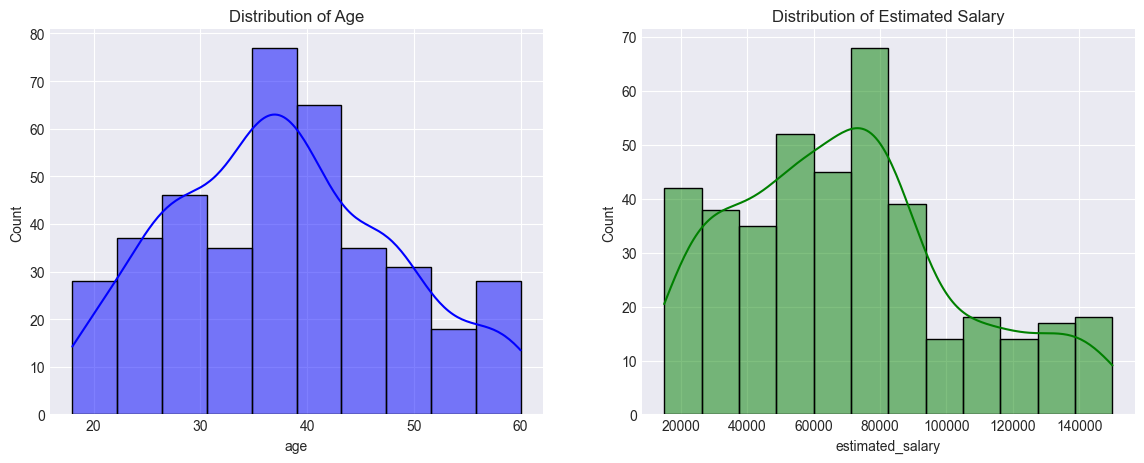

In [16]:
# 3.1 Univariate Analysis: Distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Age Distribution
sns.histplot(df['age'], kde=True, ax=axes[0], color='blue')
axes[0].set_title('Distribution of Age')

# Estimated Salary Distribution
sns.histplot(df['estimated_salary'], kde=True, ax=axes[1], color='green')
axes[1].set_title('Distribution of Estimated Salary')

plt.show()

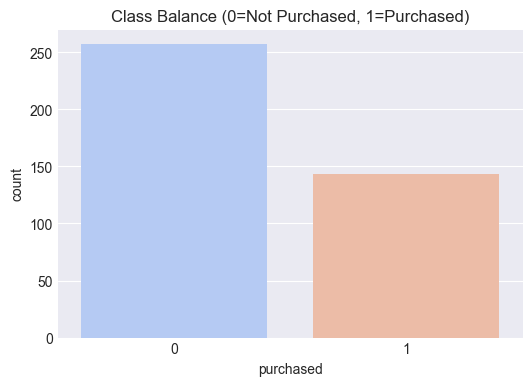

purchased
0    0.6425
1    0.3575
Name: proportion, dtype: float64


In [18]:
# 3.2 Target Class Balance
plt.figure(figsize=(6, 4))
sns.countplot(x='purchased', data=df, palette='coolwarm')
plt.title('Class Balance (0=Not Purchased, 1=Purchased)')
plt.show()

print(df['purchased'].value_counts(normalize=True))

#### Insight (Class Balance):
We can identify if the dataset is imbalanced. If `0 (Not Purchased)` is significantly higher than `1 (Purchased)`, model accuracy might be biased towards the majority class.

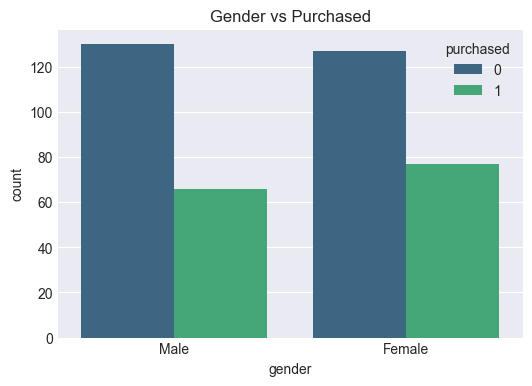

In [20]:
# 3.3 Bivariate Analysis: Gender vs Purchased
plt.figure(figsize=(6, 4))
sns.countplot(x='gender', hue='purchased', data=df, palette='viridis')
plt.title('Gender vs Purchased')
plt.show()

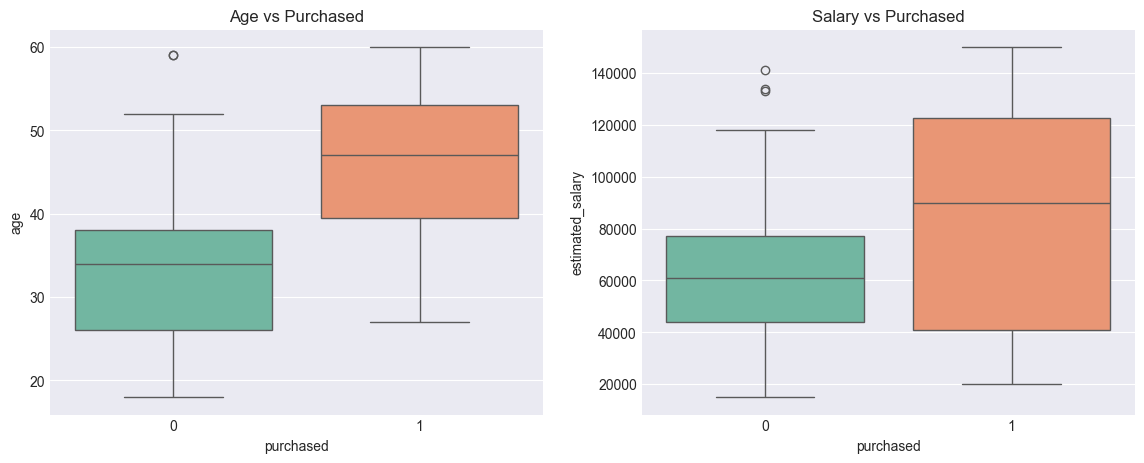

In [21]:
# 3.4 Bivariate Analysis: Age & Salary Impact on Purchase
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(x='purchased', y='age', data=df, ax=axes[0], palette='Set2')
axes[0].set_title('Age vs Purchased')

sns.boxplot(x='purchased', y='estimated_salary', data=df, ax=axes[1], palette='Set2')
axes[1].set_title('Salary vs Purchased')

plt.show()

#### Insight:
- From the boxplots, observe if **older people** are more likely to buy the SUV.
- Check if **higher salary** correlates with purchasing.

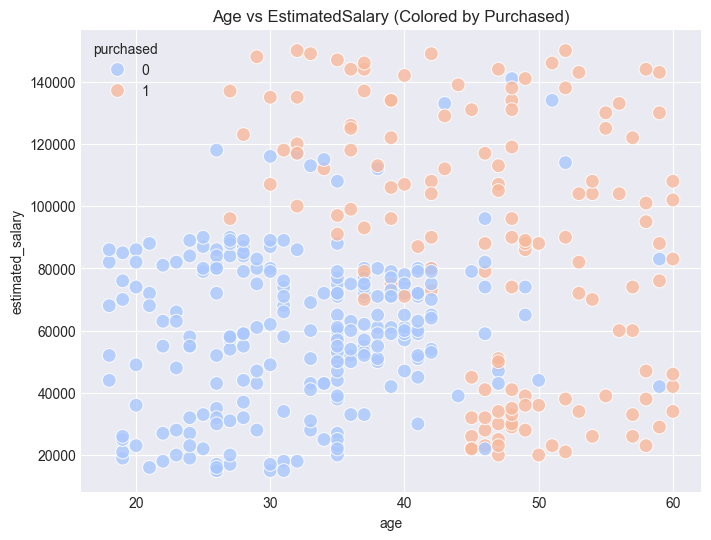

In [25]:
# 3.5 Multivariate Analysis: Scatter Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='age', y='estimated_salary', hue='purchased', data=df, palette='coolwarm', s=100, alpha=0.8)
plt.title('Age vs EstimatedSalary (Colored by Purchased)')
plt.show()

#### Insight:
The scatter plot should visually show a decision boundary. We expect to see a cluster of "Purchased (1)" in the top-right corner (Older & Higher Income).

---
# STEP 4: Data Cleaning

In [24]:
# 4.1 Check Missing Values
print(df.isnull().sum())

gender              0
age                 0
estimated_salary    0
purchased           0
dtype: int64


In [23]:
# 4.2 Check Duplicates
duplicates = df.duplicated().sum()
print(f"Duplicate Rows: {duplicates}")
if duplicates > 0:
    df.drop_duplicates(inplace=True)
    print("Duplicates Removed.")

Duplicate Rows: 20
Duplicates Removed.


In [22]:
# 4.3 Outlier Detection (Using IQR on Salary)
Q1 = df['estimated_salary'].quantile(0.25)
Q3 = df['estimated_salary'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Salary Outlier Bounds: {lower_bound} - {upper_bound}")

outliers = df[(df['estimated_salary'] < lower_bound) | (df['estimated_salary'] > upper_bound)]
print(f"Number of Outliers detected: {outliers.shape[0]}")

# Decision: If very few, we can keep them or remove. For this dataset, usually there are none or very few.

Salary Outlier Bounds: -24500.0 - 155500.0
Number of Outliers detected: 0


---
# STEP 5: Data Preprocessing
Preparing data for the Logistic Regression model.

In [26]:
# 5.1 Encoding Categorical Variables
# Gender (Male/Female) -> (1/0)
# We can use LabelEncoder or simple mapping since it's binary

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['gender'] = le.fit_transform(df['gender'])

print("Gender encoded. Classes:", le.classes_)
df.head()

Gender encoded. Classes: ['Female' 'Male']


,gender,age,estimated_salary,purchased
0,1,19,19000,0
1,1,35,20000,0
2,0,26,43000,0
3,0,27,57000,0
4,1,19,76000,0


In [27]:
# 5.2 Feature Selection
X = df[['age', 'estimated_salary']]
y = df['purchased']

# Note: We are keeping 'Age' and 'Salary' as they are the main predictors.
# Gender is often less significant for this dataset, but we could include it if we wanted.
# For this demo, let's stick to Age and Salary to visualize the 2D decision boundary easily.

In [29]:
# 5.3 Feature Scaling (StandardScaler)
# CRITICAL for Logistic Regression because it uses gradient descent optimization.
# Age (18-60) and Salary (15k-150k) have vastly different scales.

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Features Scaled (Mean ~ 0, Variance ~ 1)")
print(X_scaled[:5])

Features Scaled (Mean ~ 0, Variance ~ 1)
[[-1.75703199 -1.48793823]
 [-0.24453666 -1.45900186]
 [-1.09531528 -0.79346552]
 [-1.00078432 -0.38835645]
 [-1.75703199  0.16143444]]


---
# STEP 6: Train-Test Split

In [30]:
from sklearn.model_selection import train_test_split

# 80% Training, 20% Testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")

Training Data Shape: (304, 2)
Testing Data Shape: (76, 2)


---
# STEP 7: Model Selection
We chose **Logistic Regression** for this task.

### Why Logistic Regression?
1. **Sigmoid Function:** Unlike Linear Regression which outputs raw numbers, Logistic Regression puts the output through a Sigmoid (S-curve) function to squash it between 0 and 1. This is perfect for probabilities.
2. **Linear Decision Boundary:** It tries to find a straight line (or plane) that best separates Purchased=1 from Purchased=0.
3. **Interpretability:** We can easily see which feature (Age or Salary) has a stronger effect on the purchase decision.

---
# STEP 8: Model Training

In [31]:
from sklearn.linear_model import LogisticRegression

# Train the model
classifier = LogisticRegression(random_state=42)
classifier.fit(X_train, y_train)

print("Model Trained Successfully!")
print(f"Intercept: {classifier.intercept_}")
print(f"Coefficients (Age, Salary): {classifier.coef_}")

Model Trained Successfully!
Intercept: [-0.9179795]
Coefficients (Age, Salary): [[2.25403107 1.13522847]]


#### Coefficient Interpretation:
Positive coefficients mean that as the feature value increases (e.g., higher Age), the probability of Purchasing `(1)` increases.
If `Age` coefficient > `Salary` coefficient, then Age is a stronger predictor.

---
# STEP 9: Model Evaluation

In [32]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Predict on Test Set
y_pred = classifier.predict(X_test)

# Accuracy
print(f"Accuracy Score: {accuracy_score(y_test, y_pred) * 100:.2f}%")

# Detailed Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy Score: 82.89%

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.85      0.86        48
           1       0.76      0.79      0.77        28

    accuracy                           0.83        76
   macro avg       0.82      0.82      0.82        76
weighted avg       0.83      0.83      0.83        76



---
# STEP 10: Model Visualization
Visualizing the Decision Boundary and Confusion Matrix.

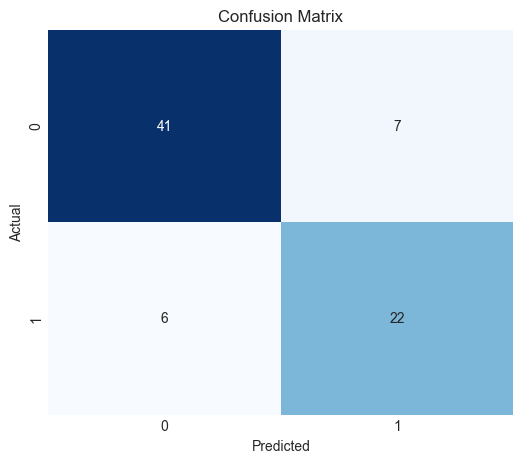

In [33]:
# 10.1 Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

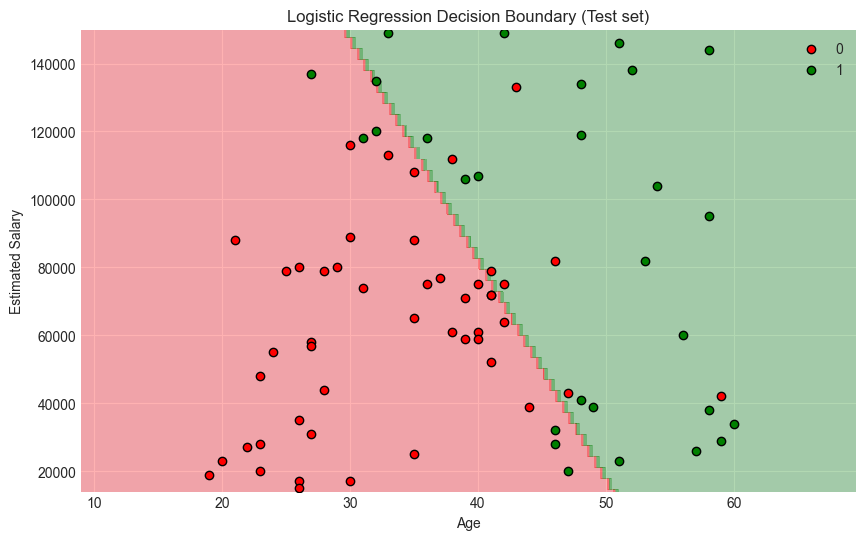

In [34]:
# 10.2 Decision Boundary Visualization
from matplotlib.colors import ListedColormap

X_set, y_set = scaler.inverse_transform(X_test), y_test
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 10, stop = X_set[:, 0].max() + 10, step = 0.5),
                     np.arange(start = X_set[:, 1].min() - 1000, stop = X_set[:, 1].max() + 1000, step = 0.5))

# Note: This visualization step is heavy because it predicts for every pixel. 
# We need to transform the grid back to scaled values for prediction, then plot.
# A simpler approach for huge datasets is to just plot the test points over the decision contour.

plt.figure(figsize=(10, 6))

# Plotting the decision boundary contour
# We predict on the grid points (scaled)
grid_predictions = classifier.predict(scaler.transform(np.array([X1.ravel(), X2.ravel()]).T)).reshape(X1.shape)

plt.contourf(X1, X2, grid_predictions, alpha = 0.3, cmap = ListedColormap(('red', 'green')))

# Plot the actual data points
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j, edgecolor='k')

plt.title('Logistic Regression Decision Boundary (Test set)')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend()
plt.show()

---
# STEP 11: Prediction
Predicting for a new user.

In [35]:
# New User: Age 30, Salary 87000
new_user_age = 30
new_user_salary = 87000

# Don't forget to scale the input!
new_data = scaler.transform([[new_user_age, new_user_salary]])
prediction = classifier.predict(new_data)
probability = classifier.predict_proba(new_data)

print(f"User: Age {new_user_age}, Salary ${new_user_salary}")
print(f"Prediction: {'Purchased' if prediction[0] == 1 else 'Not Purchased'}")
print(f"Probability of Purchase: {probability[0][1]*100:.2f}%")

User: Age 30, Salary $87000
Prediction: Not Purchased
Probability of Purchase: 12.03%


---
# STEP 12: Final Conclusion

### 12.1 Key Insights
- **Age Factor:** Older users are significantly more likely to purchase the SUV. This is the strongest predictor.
- **Salary Factor:** Higher salary also increases purchase likelihood, but Age seems to define the primary cluster.
- **Decision Boundary:** The Logistic Regression finds a linear boundary. It works well, but there is some overlap in the middle (middle-aged, middle-income) where it makes some mistakes.

### 12.2 Limitations & Improvements
- **Linearity:** Logistic Regression assumes a linear separation. If the relationship was more complex (e.g., only young *and* rich people buy), a non-linear model like **Kernel SVM** or **Random Forest** might perform better.
- **Gender:** We excluded gender for 2D visualization, but adding it might squeeze out a bit more accuracy.

### 12.3 Marketing Recommendation
- Target ads primarily to **users above 40 years old**.
- Target younger users only if they have a **very high salary**.